# Creative Gaming: Propensity-to-Buy Modeling

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pyrsm as rsm
import os

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150

# checking pyrsm version
rsm.__version__  # should be 0.9.16 or higher

'0.9.16'

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

In [3]:
cg_organic = pd.read_parquet("data/cg_organic.parquet")
rsm.md("data/cg_organic_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")
* training: Dummy variable that splits the dataset into a training (1) and test (0) dataset


In [4]:
cg_organic

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,training
34184,no,10,11,0,355,0,8,3,yes,no,...,0,5,0,no,no,4,2953,yes,yes,1
192849,no,6,7,1,30,0,0,0,yes,no,...,0,0,0,no,yes,8,2343,yes,no,1
84958,no,8,2,0,69,0,111,13,no,no,...,0,0,0,yes,no,11,2374,yes,no,1
120745,no,5,3,0,40,0,33,1,no,no,...,0,2,0,no,no,3,2708,yes,no,1
137887,no,6,15,0,5,0,62,0,no,no,...,0,0,0,no,no,11,2101,yes,yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143641,no,1,12,0,0,0,2,0,no,no,...,0,0,0,yes,no,3,2619,no,no,0
149842,no,4,9,0,0,0,7,8,no,no,...,0,3,7,no,no,21,3835,yes,no,0
155445,no,5,18,0,1,0,0,0,no,no,...,0,0,0,no,no,4,3562,yes,yes,1
159416,no,8,22,0,83,0,0,0,no,no,...,0,0,0,no,no,10,3258,yes,no,1


## Part I: Exploratory Analytics

First, to gain an understanding of whether the data is appropriate for predictive analytics, you decide to engage in some exploratory analytics. 

- What is the probability of organically converting to Zalon? 

In [5]:
cg_organic["converted_yes"] = rsm.ifelse(cg_organic.converted == "yes", 1, 0)
q1 = cg_organic.groupby("converted", observed=False).converted.agg(n_obs="count")
q1["perc"] = (100 * q1 / q1.sum()).round(2).astype(str) + "%"
q1

,n_obs,perc
converted,,
yes,1726,5.75%
no,28274,94.25%


- Basic summary statistics for each feature in the data (For numeric variables show the number of observations, the number of missing values, the number of distinct values, and the mean, min, max, and standard deviation. For non-numeric variables show the number of observations, the number of missing values, the number of distinct values, the most common level, and the least common level)

In [6]:
def n_missing(x):
    return x.isna().sum()


is_num = [
    c for c in cg_organic.columns if pd.api.types.is_numeric_dtype(cg_organic[c].dtype)
]

cg_organic[is_num].agg(
    ["count", "nunique", n_missing, "mean", "min", "max", "std"]
).transpose()

,count,nunique,n_missing,mean,min,max,std
GameLevel,30000.0,10.0,0.0,6.246733,1.0,10.0,2.774055
NumGameDays,30000.0,28.0,0.0,12.241400,1.0,28.0,7.097305
NumGameDays4Plus,30000.0,25.0,0.0,1.257267,0.0,24.0,3.191210
NumInGameMessagesSent,30000.0,641.0,0.0,73.777400,0.0,1227.0,107.441593
NumSpaceHeroBadges,30000.0,13.0,0.0,0.443933,0.0,12.0,1.517762
NumFriendRequestIgnored,30000.0,122.0,0.0,29.589100,0.0,121.0,33.990783
NumFriends,30000.0,485.0,0.0,47.733833,0.0,486.0,94.329939
TimesLostSpaceship,30000.0,143.0,0.0,4.435567,0.0,298.0,11.546392
TimesKilled,30000.0,72.0,0.0,0.293400,0.0,178.0,3.415129
TimesCaptain,30000.0,120.0,0.0,1.583033,0.0,429.0,8.770534


In [7]:
def most_common(x):
    return x.value_counts().idxmax()


def least_common(x):
    return x.value_counts().idxmin()


is_not_num = [c for c in cg_organic.columns if not c in is_num]
cg_organic[is_not_num].agg(
    ["count", "nunique", n_missing, most_common, least_common]
).transpose()

,count,nunique,n_missing,most_common,least_common
converted,30000,2,0,no,yes
AcquiredSpaceship,30000,2,0,no,yes
AcquiredIonWeapon,30000,2,0,no,yes
PurchasedCoinPackSmall,30000,2,0,no,yes
PurchasedCoinPackLarge,30000,2,0,no,yes
UserConsole,30000,2,0,yes,no
UserHasOldOS,30000,2,0,no,yes


- Histograms for all numeric variables and frequency plots for non-numeric variables 

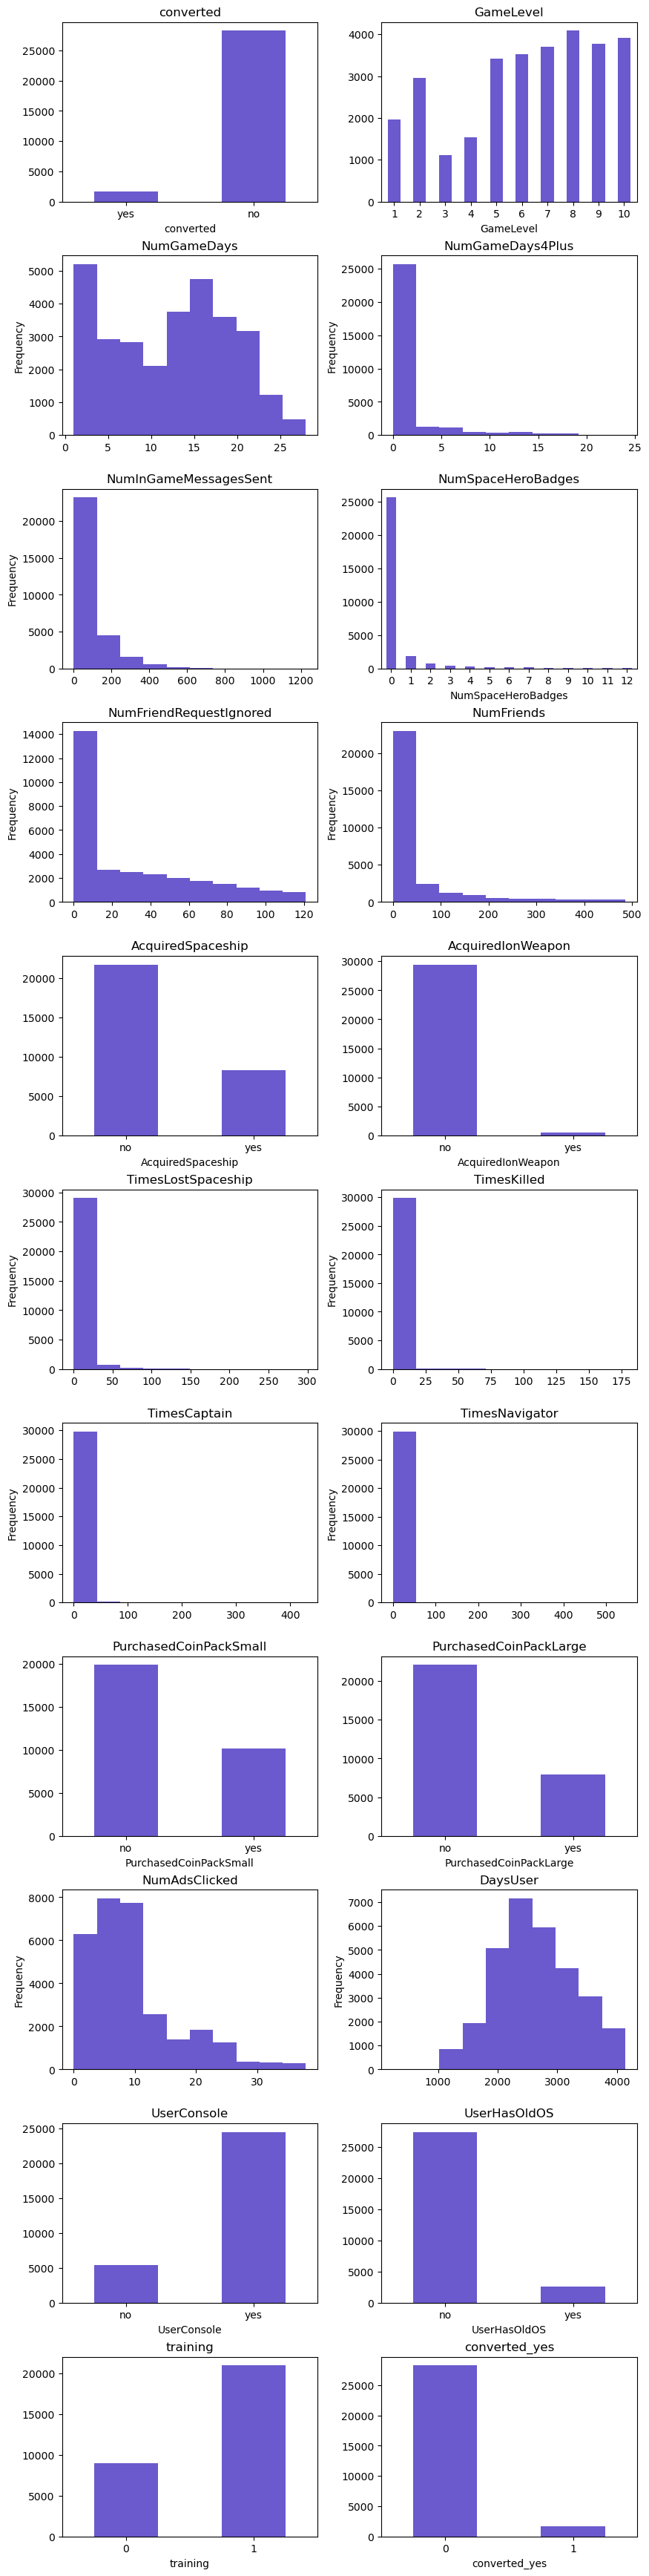

In [8]:
rsm.distr_plot(cg_organic)

## Part II: Predictive Model

- Train a logistic regression model using all features and use the "training" variable to set a filter ("training == 1").

> Note: Since we will use this model several times, set the name of the model object to `lr_organic`.

In [9]:
cg_organic.columns

Index(['converted', 'GameLevel', 'NumGameDays', 'NumGameDays4Plus',
       'NumInGameMessagesSent', 'NumSpaceHeroBadges',
       'NumFriendRequestIgnored', 'NumFriends', 'AcquiredSpaceship',
       'AcquiredIonWeapon', 'TimesLostSpaceship', 'TimesKilled',
       'TimesCaptain', 'TimesNavigator', 'PurchasedCoinPackSmall',
       'PurchasedCoinPackLarge', 'NumAdsClicked', 'DaysUser', 'UserConsole',
       'UserHasOldOS', 'training', 'converted_yes'],
      dtype='object')

In [10]:
evar = list(cg_organic.columns) #[1:][:-2]
evar = evar[evar.index("GameLevel"):][:evar.index("UserHasOldOS")].copy()
evar

['GameLevel',
 'NumGameDays',
 'NumGameDays4Plus',
 'NumInGameMessagesSent',
 'NumSpaceHeroBadges',
 'NumFriendRequestIgnored',
 'NumFriends',
 'AcquiredSpaceship',
 'AcquiredIonWeapon',
 'TimesLostSpaceship',
 'TimesKilled',
 'TimesCaptain',
 'TimesNavigator',
 'PurchasedCoinPackSmall',
 'PurchasedCoinPackLarge',
 'NumAdsClicked',
 'DaysUser',
 'UserConsole',
 'UserHasOldOS']

In [11]:
lr_organic = rsm.model.logistic(
    data={"cg_organic": cg_organic[cg_organic.training == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
)
lr_organic.summary(main=False, fit=True)


Pseudo R-squared (McFadden): 0.184
Pseudo R-squared (McFadden adjusted): 0.18
Area under the RO Curve (AUC): 0.82
Log-likelihood: -3719.041, AIC: 7478.081, BIC: 7637.127
Chi-squared: 1682.617, df(19), p.value < 0.001 
Nr obs: 21,000


In [12]:
lr_organic.coef.round(3)

,index,OR,OR%,coefficient,std.error,z.value,p.value,
0,Intercept,0.009,-99.139,-4.755,0.190,-24.997,0.000,***
1,AcquiredSpaceship[T.yes],1.713,71.295,0.538,0.072,7.486,0.000,***
2,AcquiredIonWeapon[T.yes],1.613,61.277,0.478,0.203,2.353,0.019,*
3,PurchasedCoinPackSmall[T.yes],0.912,-8.828,-0.092,0.070,-1.316,0.188,
4,PurchasedCoinPackLarge[T.yes],1.270,26.990,0.239,0.073,3.257,0.001,**
5,UserConsole[T.yes],1.203,20.346,0.185,0.091,2.025,0.043,*
6,UserHasOldOS[T.yes],0.847,-15.337,-0.166,0.124,-1.341,0.180,
7,GameLevel,1.109,10.915,0.104,0.014,7.380,0.000,***
8,NumGameDays,1.034,3.365,0.033,0.005,6.058,0.000,***
9,NumGameDays4Plus,1.042,4.171,0.041,0.009,4.648,0.000,***


- 5 most important features?

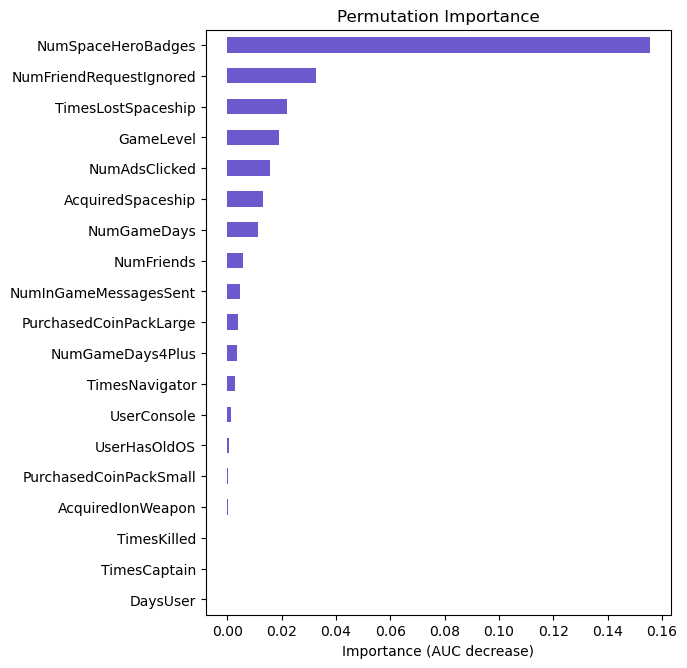

In [13]:
lr_organic.plot("vimp")

The most important features are, in order, "NumSpaceHeroBadges", "NumFriendRequestIgnored", "TimesLostSpaceship", "GameLevel", and "NumAdsClicked".

- Prediction plots for each of these 5 features and summarize your findings

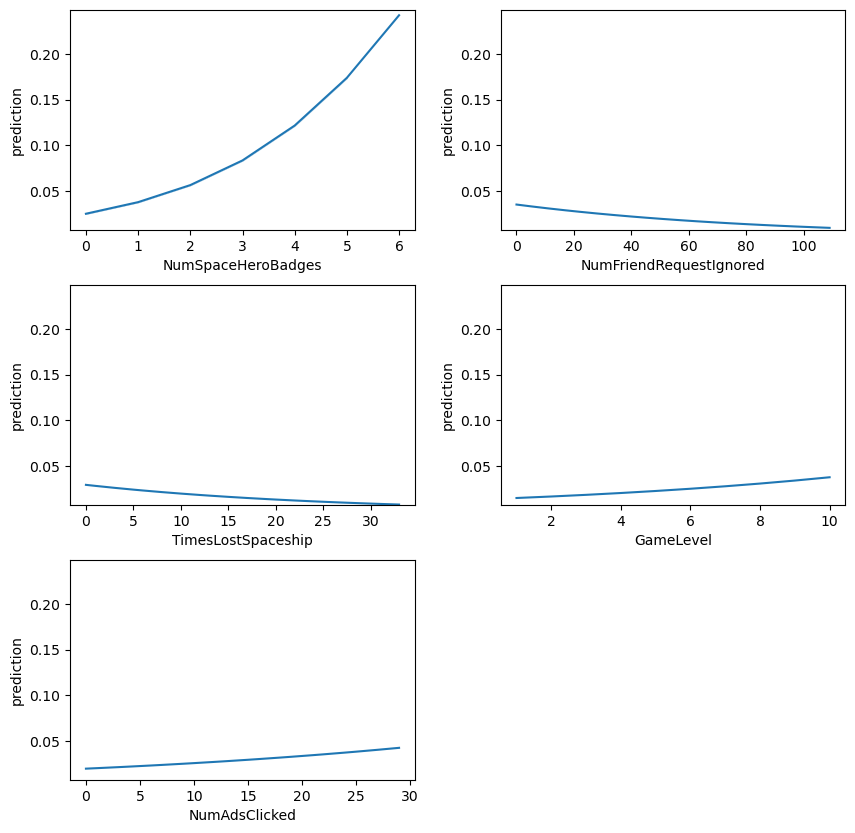

In [14]:
lr_organic.plot(
    "pred",
    incl=[
        "NumSpaceHeroBadges",
        "NumFriendRequestIgnored",
        "TimesLostSpaceship",
        "GameLevel",
        "NumAdsClicked",
    ],
)

The prediction plot for NumSpaceHeroBadges shows a strong positive effect, keeping all other variables in the model constant. For each additional badge, a gamer's probability of purchasing the Salon campaign increase. Getting badges demonstrates skill and engagement with the game.

We see positive effects, although not as strong, for GameLevel and NumAdsClicked, keeping all other variables in the model constant. As GameLevel and NumAdsClicked increase, the probability that the gamer purchase the Salon campaign increases. Higher GameLevel values demonstrates skill and engagement with the game. Previous clicks on ads, suggest the customer is interested in new campaign information coming from CG.

We see negative effects for NumFriendRequestIgnored and  TimesLostSpaceShip, keeping all other variables in the model constant. As NumFriendRequestIgnored and  TimesLostSpaceShipGameLevel increase, the probability that the gamer purchase the Salon campaign increases. Ignoring friend requests and losing space ships demonstrate a lack of skill and likely lower engagement with the game.

- A new variable "pred_logit" with predictions from the logistic regression model for all rows in the data

In [15]:
cg_organic["pred_logit"] = lr_organic.predict(cg_organic)["prediction"] #.iloc[:, -1]

In [16]:
cg_organic

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,training,converted_yes,pred_logit
34184,no,10,11,0,355,0,8,3,yes,no,...,0,no,no,4,2953,yes,yes,1,0,0.073430
192849,no,6,7,1,30,0,0,0,yes,no,...,0,no,yes,8,2343,yes,no,1,0,0.056571
84958,no,8,2,0,69,0,111,13,no,no,...,0,yes,no,11,2374,yes,no,1,0,0.008457
120745,no,5,3,0,40,0,33,1,no,no,...,0,no,no,3,2708,yes,no,1,0,0.014371
137887,no,6,15,0,5,0,62,0,no,no,...,0,no,no,11,2101,yes,yes,0,0,0.016892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143641,no,1,12,0,0,0,2,0,no,no,...,0,yes,no,3,2619,no,no,0,0,0.010917
149842,no,4,9,0,0,0,7,8,no,no,...,7,no,no,21,3835,yes,no,0,0,0.027490
155445,no,5,18,0,1,0,0,0,no,no,...,0,no,no,4,3562,yes,yes,1,0,0.028257
159416,no,8,22,0,83,0,0,0,no,no,...,0,no,no,10,3258,yes,no,1,0,0.063954


- Gains curves for both the training and test set using the "pred_logit" variable

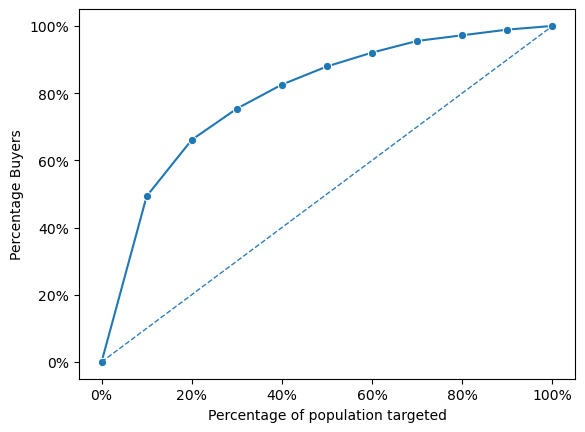

In [17]:
fig = rsm.gains_plot(
    cg_organic.query("training == 1"), "converted", "yes", "pred_logit", qnt=10
)

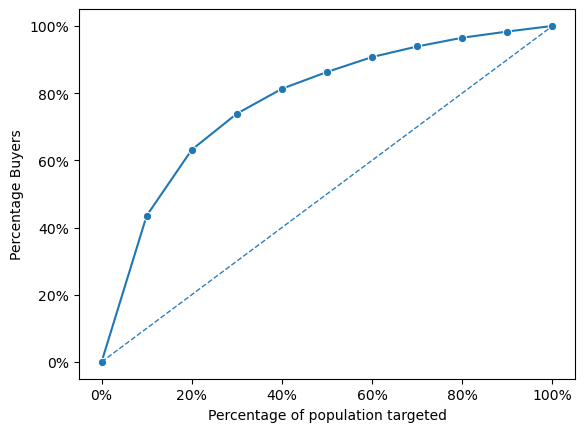

In [18]:
fig = rsm.gains_plot(
    cg_organic.query("training == 0"), "converted", "yes", "pred_logit", qnt=10
)

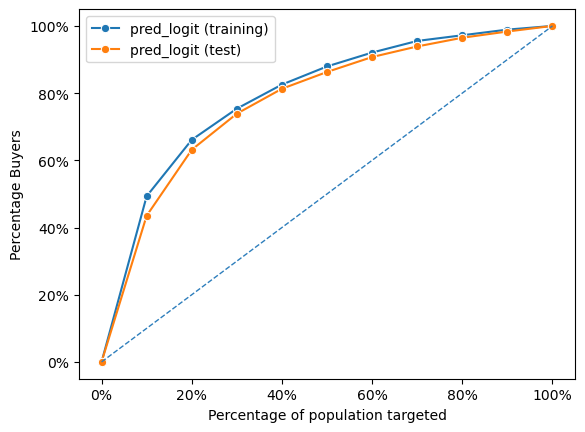

In [19]:
dct = {
    "training": cg_organic.query("training == 1"),
    "test": cg_organic.query("training == 0"),
}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_logit", qnt=10)

- AUC of the model in both the training and test set


In [20]:
rsm.auc(
    cg_organic.loc[cg_organic.training == 1, "converted"],
    cg_organic.loc[cg_organic.training == 1, "pred_logit"],
    lev="yes",
).round(3)

0.82

In [21]:
rsm.auc(
    cg_organic.loc[cg_organic.training == 0, "converted"],
    cg_organic.loc[cg_organic.training == 0, "pred_logit"],
    lev="yes",
).round(3)

0.803

## Part III: The Ad-Experiment 

We have finished building a logistic regression model to predict what kind of Space Pirates gamers were more or less likely to purchase the Zalon campaign. After debriefing Mi Haruki on the performance of the predictive model, she lays out the next steps:

"We will test the effectiveness of the in-app ad and the predictive model by exposing a random 150,000 customers to a 2-week ad campaign and measuring their conversion to Zalon over the next 2 months. At the same time, we will randomly pick another 30,000 customers and observe their organic upgrade behavior over the same period. This set of customers will not be served any in-app ads.

I want you to compare three groups based on this data.

Group 1: The randomly picked 30,000 Space Pirates gamers who did not receive in-app ads during the experimental period.

Group 2: A randomly picked 30,000 Space Pirates gamers among the 150,000 who were served in-app ads for Zalon.

Group 3: A model-selected 30,000 Space Pirates gamers among the 120,000 (after taking out Group 2) who were served in-app ads for Zalon.

Please report back to me how well the ads are working in terms of conversion rates and profits and by how much the model improves these metrics, all based on targeting 30,000 customers. To calculate profits, please use revenues of $14.99 from selling Zalon. The cost of serving ads to a consumer for 2 weeks is $1.50 in lost coin purchases."

- Calculate the response rate and profit of group 1. The dataset containing the data for group 1 is named "data/cg_organic_control.parquet".

In [22]:
## loading the data - this dataset must NOT be changed
cg_organic_control = pd.read_parquet("data/cg_organic_control.parquet")
rsm.md("data/cg_organic_control_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode)
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")


In [23]:
cg_organic_control["converted_yes"] = rsm.ifelse(
    cg_organic_control.converted == "yes", 1, 0
)
result = cg_organic_control.converted_yes.agg(
    customers="count", converted="sum", conv_rate="mean"
)
conv_rate_no_ad = result["conv_rate"]
result

customers    30000.000000
converted     1706.000000
conv_rate        0.056867
Name: converted_yes, dtype: float64

In [24]:
profit_no_ad = result["converted"] * 14.99
format(profit_no_ad, ",.2f")

'25,572.94'

In [25]:
cg_organic_control["pred_all"] = 1
perf_no_ad = rsm.evalbin(
    cg_organic_control, "converted", "yes", "pred_all", cost=0, margin=14.99
)
perf_no_ad

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,pred_all,1706,28294,0,0,30000,1.0,0.0,0.057,0.108,0.057,0.0,25572.94,1.0,NaN,1.0,0.5


In [26]:
format(perf_no_ad.loc[0, "profit"], ",.2f")

'25,572.94'

The dataset needed to evaluate groups 2 and 3 is "data/cg_ad_treatment.parquet". All customers in this dataset were exposed to advertising as part of the experiment.

- Calculate the response rate and profit of group 2. Set a filter "rnd_30k == 1" to select the 30,000 customers from the 150,000 rows in "cg_ad_treatment".

In [27]:
## loading the data - this dataset must NOT be changed
cg_ad_treatment = pd.read_parquet("data/cg_ad_treatment.parquet")
rsm.md("data/cg_ad_treatment_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")
* rnd_30k: Dummy variable that randomly selects 30K customers (1) and the remaining 90K (0)


In [28]:
cg_ad_treatment["converted_yes"] = rsm.ifelse(cg_ad_treatment.converted == "yes", 1, 0)
result = cg_ad_treatment.query("rnd_30k == 1").converted_yes.agg(
    customers="count", converted="sum", conv_rate="mean"
)
conv_rate_ad_treatment = result["conv_rate"]
result

customers    30000.000000
converted     3913.000000
conv_rate        0.130433
Name: converted_yes, dtype: float64

In [29]:
profit_ad_treatment = result["converted"] * 14.99 - result["customers"] * 1.5
format(profit_ad_treatment, ",.2f")

'13,655.87'

In [30]:
cg_ad_treatment["pred_all"] = 1
profit_ad_treatment = rsm.evalbin(
    cg_ad_treatment.query("rnd_30k == 1"),
    "converted",
    "yes",
    "pred_all",
    cost=1.5,
    margin=14.99,
).loc[0, "profit"]
format(profit_ad_treatment, ",.2f")

'13,655.87'

- Calculate the response rate and profit of group 3.

a.	Use the logistic regression model we trained in Part II to predict the probability of purchasing the Zalon campaign (i.e., score) all 150,000 gamers in the "cg_ad_treatment".

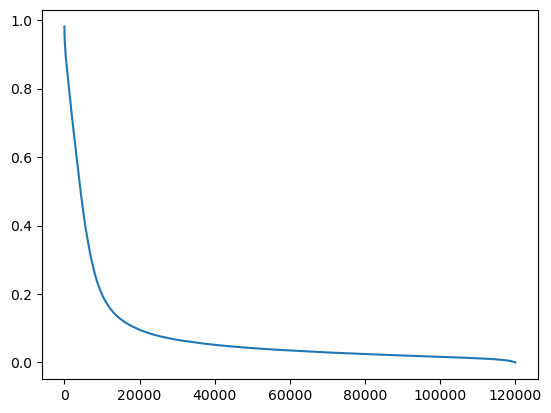

In [31]:
cg_ad_treatment["pred_logit"] = lr_organic.predict(cg_ad_treatment).iloc[:, -1]
fig = (
    cg_ad_treatment.query("rnd_30k == 0")
    .sort_values("pred_logit", ascending=False)
    .reset_index(drop=True)
    .pred_logit.plot.line()
)

b. Select the 30,000 customers with best predictions (scores) that are not part of group 2. Use only these 30,000 to compute conversion rates and profits of group 3.

In [32]:
result = (
    cg_ad_treatment.query("rnd_30k == 0")
    .sort_values("pred_logit", ascending=False)
    .iloc[:30000]
    .converted_yes.agg(customers="count", converted="sum", conv_rate="mean")
)
conv_rate_ad_scoring = result["conv_rate"]
result

customers    30000.000000
converted     6452.000000
conv_rate        0.215067
Name: converted_yes, dtype: float64

In [33]:
profit_ad_scoring = result["converted"] * 14.99 - result["customers"] * 1.5
format(profit_ad_scoring, ",.2f")

'51,715.48'

In [34]:
cg_ad_treatment["pred_all"] = 1
profit_ad_scoring = rsm.evalbin(
    cg_ad_treatment.query("rnd_30k == 0")
    .sort_values("pred_logit", ascending=False)
    .iloc[:30000],
    "converted",
    "yes",
    "pred_all",
    cost=1.5,
    margin=14.99,
).loc[0, "profit"]
format(profit_ad_scoring, ",.2f")

'51,715.48'

There is a cost of advertising but we are still going to target everyone where the filter is `rnd_30k == 0` and the customer is among the 30K with the highest predicted probabilities (scores) so we can use the `evalbin` to calculate profitability  **if** we select a variable that has values that are always above the breakeven threshold.

- To answer Mi Haruki’s question: "Please report back to me how well the ads are working in terms of conversion rates and profits and by how much the model improves these metrics, all based on targeting 30,000 customers." 

Reminder of the numbers:

Group 1 (organic control): 

In [35]:
format(profit_no_ad, ",.2f")

'25,572.94'

Group 2 (ad treatment): 

In [36]:
format(profit_ad_treatment, ",.2f")

'13,655.87'


Group 3 (model selection): 



In [37]:
format(profit_ad_scoring, ",.2f")

'51,715.48'

> Note: Can use `rsm.md` to help automate reporting of numeric results. Any changes to data or calculations will be printed out in a format that is easily included in emails, chat, or slides.

In [38]:
rsm.md(
    f"""
The ad increases conversion rates from {100 * conv_rate_no_ad:.2f}% to 
{100 * conv_rate_ad_treatment:.2f}%. However, profits decrease from 
{profit_no_ad:,.0f} to {profit_ad_treatment:,.0f}. Conditional on 
showing an ad, the model increases conversion rates from {100 * conv_rate_ad_treatment:.2f}%
to {100 * conv_rate_ad_scoring:.2f}% and profits from {profit_ad_treatment:,.0f} 
to {profit_ad_scoring:,.0f}. The benefit of the ad campaign, if a model 
is used to select customers, is {profit_ad_scoring:,.0f} - {profit_no_ad:,.0f} = {profit_ad_scoring - profit_no_ad:,.0f}.
"""
)


The ad increases conversion rates from 5.69% to 
13.04%. However, profits decrease from 
25,573 to 13,656. Conditional on 
showing an ad, the model increases conversion rates from 13.04%
to 21.51% and profits from 13,656 
to 51,715. The benefit of the ad campaign, if a model 
is used to select customers, is 51,715 - 25,573 = 26,143.


- Gains curve for all customers that are not in group 2 (i.e., rnd_30k == 0). Also report the AUC of the for this set of customers. Compare the gains curve and AUC to the ones we calculated in Part II.4 and II.5. Why are they different?

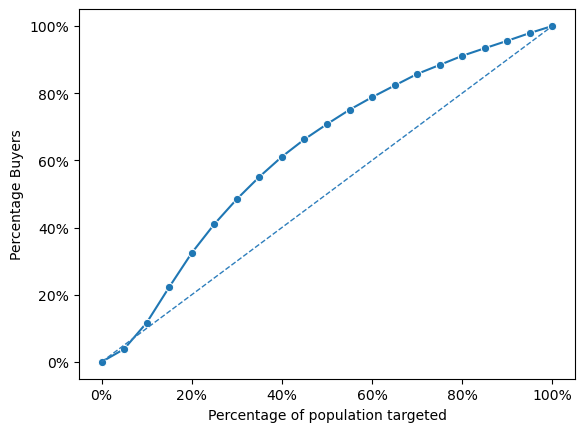

In [39]:
fig = rsm.gains_plot(
    cg_ad_treatment.query("rnd_30k == 0"), "converted", "yes", "pred_logit", qnt=20
)

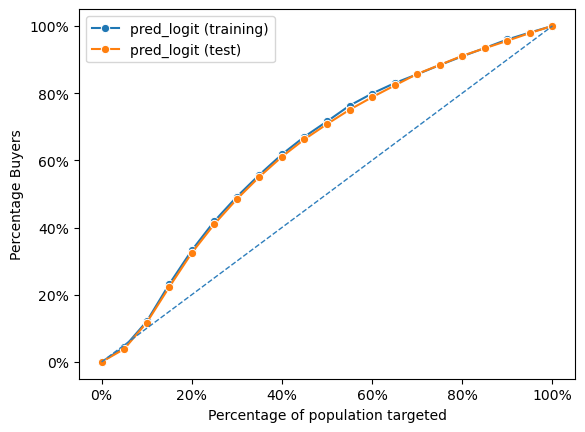

In [40]:
dct = {
    "training": cg_ad_treatment.query("rnd_30k == 1"),
    "test": cg_ad_treatment.query("rnd_30k == 0"),
}

fig = rsm.gains_plot(dct, "converted", "yes", "pred_logit", qnt=20)

In [41]:
rsm.auc(
    cg_ad_treatment.loc[cg_ad_treatment.rnd_30k == 0, "converted_yes"],
    cg_ad_treatment.loc[cg_ad_treatment.rnd_30k == 0, "pred_logit"],
).round(3)

0.644

For reference, below are the gains curves from II.4

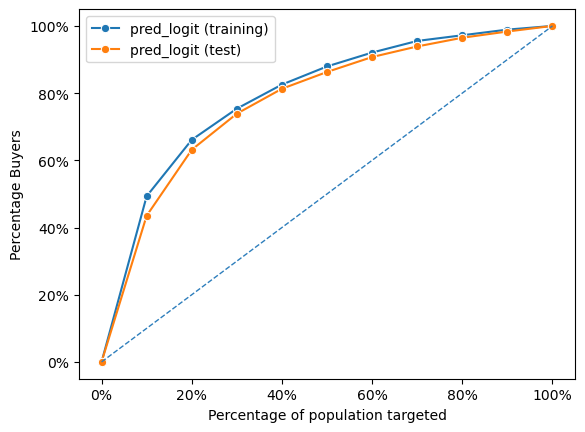

In [42]:
dct = {
    "training": cg_organic.query("training == 1"),
    "test": cg_organic.query("training == 0"),
}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_logit", qnt=10)

For reference, below are AUC scores from II.5

In [43]:
rsm.auc(
    cg_organic.loc[cg_organic.training == 1, "converted"],
    cg_organic.loc[cg_organic.training == 1, "pred_logit"],
    lev="yes",
).round(3)

0.82

In [44]:
rsm.auc(
    cg_organic.loc[cg_organic.training == 0, "converted"],
    cg_organic.loc[cg_organic.training == 0, "pred_logit"],
    lev="yes",
).round(3)

0.803

The AUC and gains are lower in Part III.5 compared to Part II.4 and Part II.5 because we trained the model on Part II on organic conversion *and* tested the model on organic conversion. In contrast, in Part III.5 we use the same model trained on organic conversion but then proceed to generate predictions for data that captures reactions to an intervention (i.e., the ad exposure). It is not surprising that the performance in this experiment is lower given that what we are trying to predict (i.e., adoption in response to an ad) is not the same as organic adoption. Put differently, we lack "situational invariance."


- What could be the value of collecting data for group 1 (cg_organic_control) given that we already had data on organic conversions from the cg_organic data?



The market environment could have changed between the time when the old organic data was collected and when the experiment was run. In this case, it appears not to have (e.g., the conversion rate of 5.75% in `cg_organic` is about the same as the 5.69% during the time of the experiment in `cg_organic_control`).

## Part IV: Better Data, Better Predictions

Mi Hiruki called for a meeting to discuss next steps. She explained:

"Before we roll out the campaign globally, we want to see whether we can use the experimental data to retrain the model. The idea is to model trial in response to the in-app ad—not just organic conversion as we did initially. We know that the in-app ad, on average, increases Zalon conversions. However, if the in-app ad works for people who would not have purchased the Zalon campaign organically, updating the model based on the in-app ad data should improve predictive performance.

Let's retrain the model based on the randomly chosen Space Pirates gamers we messaged in the experiment and see how well the updated model compares to the original model in a test sample."

- Retrain the logistic regression model from Part II on the random sample of 30K customers in "cg_ad_treatment" and generate predictions for all 150,000 customers. Label this model "lr_ad" and assign the predictions to a new variable "pred_logit_ad".

In [46]:
lr_ad = rsm.model.logistic(
    data={"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
)
lr_ad.summary()

Logistic regression (GLM)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Null hyp.: There is no effect of x on converted
Alt. hyp.: There is an effect of x on converted

                                OR     OR%  coefficient  std.error  z.value p.value     
Intercept                    0.028  -97.2%        -3.57      0.101  -35.155  < .001  ***
AcquiredSpaceship[yes]       1.092    9.2%         0.09      0.041    2.143   0.032    *
AcquiredIonWeapon[yes]       0.879  -12.1%        -0.13      0.139   -0.929   0.353     
PurchasedCoinPackSmall[yes]  1.036    3.6%         0.04      0.038    0.924  

In [47]:
lr_ad.coef[1:].round(3)

,index,OR,OR%,coefficient,std.error,z.value,p.value,
1,AcquiredSpaceship[T.yes],1.092,9.179,0.088,0.041,2.143,0.032,*
2,AcquiredIonWeapon[T.yes],0.879,-12.073,-0.129,0.139,-0.929,0.353,
3,PurchasedCoinPackSmall[T.yes],1.036,3.585,0.035,0.038,0.924,0.356,
4,PurchasedCoinPackLarge[T.yes],1.176,17.589,0.162,0.041,3.980,0.000,***
5,UserConsole[T.yes],0.951,-4.912,-0.050,0.049,-1.030,0.303,
6,UserHasOldOS[T.yes],0.814,-18.593,-0.206,0.068,-3.022,0.003,**
7,GameLevel,1.054,5.437,0.053,0.008,7.046,0.000,***
8,NumGameDays,1.015,1.538,0.015,0.003,5.155,0.000,***
9,NumGameDays4Plus,1.009,0.857,0.009,0.005,1.617,0.106,
10,NumInGameMessagesSent,1.000,-0.018,-0.000,0.000,-0.845,0.398,


In [48]:
cg_ad_treatment["pred_logit_ad"] = lr_ad.predict(cg_ad_treatment).iloc[:, -1]

In [49]:
cg_ad_treatment

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k,converted_yes,pred_all,pred_logit,pred_logit_ad
109438,no,6,16,0,0,0,0,0,yes,no,...,no,11,1827,no,no,0,0,1,0.058321,0.130246
49977,no,2,8,0,0,0,5,4,no,no,...,no,3,1889,no,yes,1,0,1,0.010403,0.041218
99506,no,6,1,0,0,0,0,0,no,no,...,yes,2,1948,yes,no,0,0,1,0.025690,0.052002
411831,yes,7,16,0,102,1,0,194,no,no,...,yes,21,3409,yes,yes,0,1,1,0.122049,0.329918
82610,no,10,1,1,233,0,23,0,no,no,...,yes,4,2922,yes,no,0,0,1,0.039185,0.074874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172637,no,6,8,0,115,0,13,0,yes,no,...,no,11,2343,yes,no,1,0,1,0.041353,0.107154
87840,no,7,19,0,0,0,0,0,no,no,...,no,1,3166,yes,no,0,0,1,0.038769,0.057251
143309,no,1,5,0,207,0,37,10,yes,no,...,yes,5,2619,yes,no,0,0,1,0.013292,0.056848
159361,no,7,19,1,0,0,88,0,no,no,...,no,9,2343,no,no,0,0,1,0.010421,0.110083


- Compare the performance of the original "organic" model from Part II and the new "ad" model across the 120,000K customers that are not in group 2. Use gains curves and AUC to make the comparison. What do we find? 


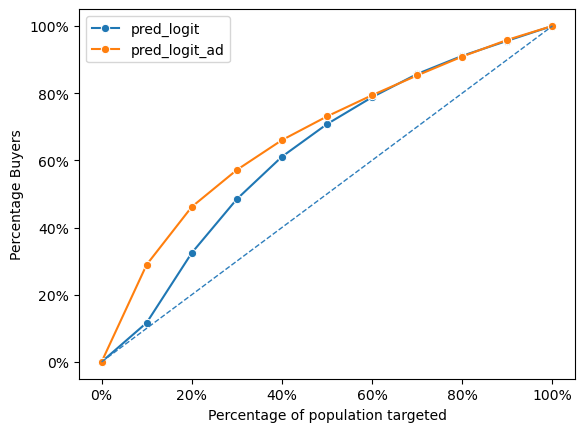

In [50]:
fig = rsm.gains_plot(
    cg_ad_treatment[cg_ad_treatment.rnd_30k == 0],
    "converted",
    "yes",
    ["pred_logit", "pred_logit_ad"],
    qnt=10,
)

In [51]:
cg_ad_treatment["pred_all"] = 1

dct = {
    "training": cg_ad_treatment.query("rnd_30k == 1"),
    "test": cg_ad_treatment.query("rnd_30k == 0"),
}
rsm.evalbin(
    dct,
    "converted",
    "yes",
    ["pred_logit", "pred_logit_ad", "pred_all"],
    cost=1.5,
    margin=14.99,
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,pred_logit,978,3726,22361,2935,30000,0.250,0.857,0.208,0.227,0.778,0.099,7604.22,0.371,1.078,0.157,0.651
1,training,pred_logit_ad,2810,11622,14465,1103,30000,0.718,0.554,0.195,0.306,0.576,0.127,20473.90,1.000,0.946,0.481,0.707
2,training,pred_all,3913,26087,0,0,30000,1.000,0.000,0.130,0.231,0.130,0.000,13655.87,0.667,0.303,1.000,0.500
3,test,pred_logit,3806,15238,89027,11929,120000,0.242,0.854,0.200,0.219,0.774,0.088,28485.94,0.343,0.997,0.159,0.644
4,test,pred_logit_ad,11305,46298,57967,4430,120000,0.718,0.556,0.196,0.308,0.577,0.129,83057.45,1.000,0.961,0.480,0.703
5,test,pred_all,15735,104265,0,0,120000,1.000,0.000,0.131,0.232,0.131,0.000,55867.65,0.673,0.310,1.000,0.500


The AUC for `pred_logit` is 0.644 in the test sample and is 0.703 for `pred_logit_ad` in the test sample. In the first case we had a model built on data without advertising trying to predict response behavior in a setting with advertising. We lack situational invariance.

- Calculate the profit improvement of using the "ad" model instead of the "organic" model to target the best 30,000 customers in the "cg_ad_treatment" data that are not in "rnd_30k == 1".

In [52]:
format(conv_rate_ad_scoring, ",.2%")

'21.51%'

In [53]:
format(profit_ad_scoring, ",.2f")

'51,715.48'

In [54]:
result = (
    cg_ad_treatment.query("rnd_30k == 0")
    .sort_values("pred_logit_ad", ascending=False)
    .iloc[:30000]
    .converted_yes.agg(customers="count", converted="sum", conv_rate="mean")
)
conv_rate_ad_scoring_ad_model = result["conv_rate"]
result

customers    30000.0000
converted     8217.0000
conv_rate        0.2739
Name: converted_yes, dtype: float64

In [55]:
profit_ad_scoring_ad_model = result["converted"] * 14.99 - result["customers"] * 1.5
format(profit_ad_scoring_ad_model, ",.2f")

'78,172.83'

In [56]:
cg_ad_treatment["pred_all"] = 1
profit_ad_scoring_ad_model = rsm.evalbin(
    cg_ad_treatment.query("rnd_30k == 0")
    .sort_values("pred_logit_ad", ascending=False)
    .iloc[:30000],
    "converted",
    "yes",
    "pred_all",
    cost=1.5,
    margin=14.99,
).loc[0, "profit"]
format(profit_ad_scoring_ad_model, ",.2f")

'78,172.83'

In [57]:
rsm.md(
    f"""
Using the ad model increases conversion rates from {100 * conv_rate_ad_scoring:.2f}% to
{100 * conv_rate_ad_scoring_ad_model:.2f}%. The benefit of the ad campaign, if the ad model
is used to select customers, is {profit_ad_scoring_ad_model:,.0f} -
{profit_ad_scoring:,.0f} = {profit_ad_scoring_ad_model - profit_ad_scoring:,.0f}.
"""
)


Using the ad model increases conversion rates from 21.51% to
27.39%. The benefit of the ad campaign, if the ad model
is used to select customers, is 78,173 -
51,715 = 26,457.


- Compare the permutation importance plot of the "organic" and the "ad" model. Why do we think the plots differ?

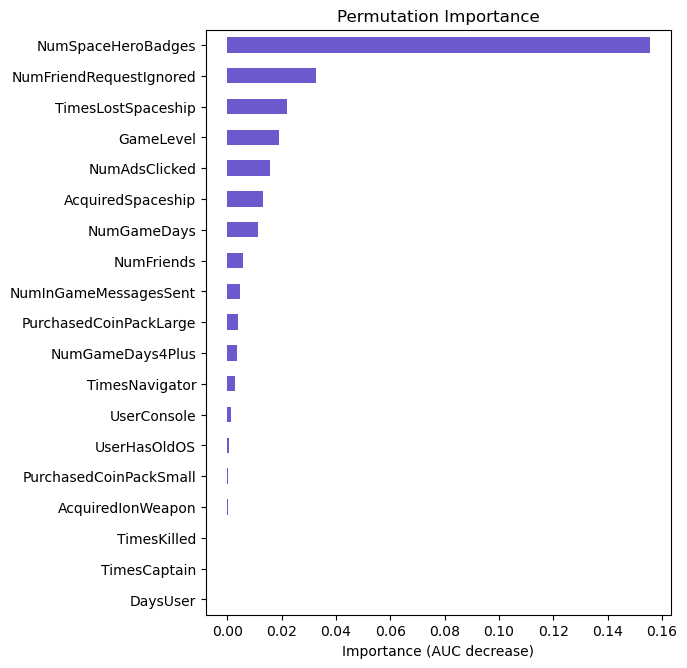

In [58]:
lr_organic.plot("vimp")

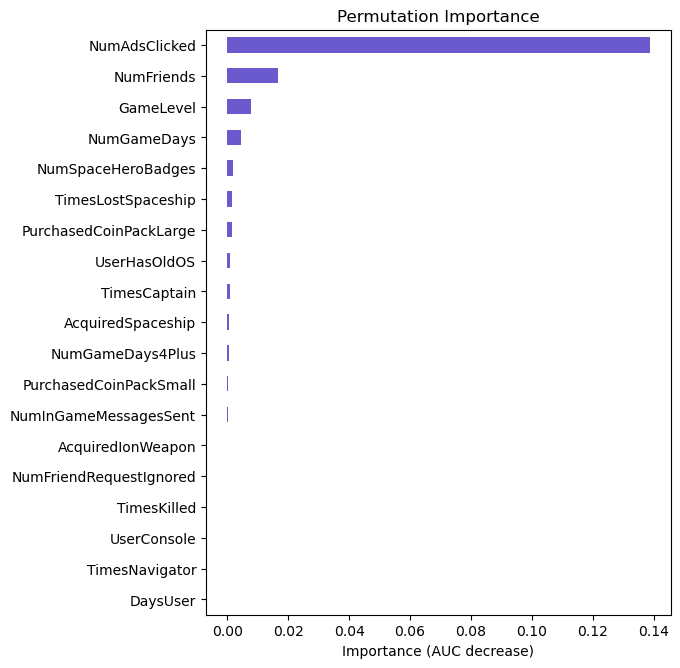

In [59]:
lr_ad.plot("vimp")

The "ad" model picks up on the fact that consumers who clicked ads previously are likely to convert when they are exposed to an ad. The organic data could not take that into account. Put differently, the ad model has "situational invariance." 

## Part V: Better Models, Better Predictions

Mi Haruki was impressed by how much performance improved when the logistic regression model was retrained on the ad treatment data rather than organic data. However, she knew that the analytics team was not done yet:

"I know we have been trying to keep the models simple and perhaps the logistic regression is what we go with. However, I want to you apply machine learning models to see if they can help improve our predictions and performance further."

- Train a neural network on the sample of customers who were exposed to the ad campaign.


In [60]:
nnc1 = rsm.model.mlp(
    data={"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
    hidden_layer_sizes=(1,),
    max_iter=100_000,
    random_state=1234,
)
nnc1.summary()

Multi-layer Perceptron (NN)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 30,000
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 100000
random_state         : 1234
AUC                  : 0.706

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends AcquiredSpaceship Acqui

In [61]:
# DataFrame that we will add all predictions to
# set the index to the same as the key dataset used
pred = pd.DataFrame(index=cg_ad_treatment.index).assign(
    rnd_30k=cg_ad_treatment.rnd_30k,
    converted_yes=cg_ad_treatment.converted_yes,
    converted=cg_ad_treatment.converted,
)
pred

,rnd_30k,converted_yes,converted
109438,0,0,no
49977,1,0,no
99506,0,0,no
411831,0,1,yes
82610,0,0,no
...,...,...,...
172637,1,0,no
87840,0,0,no
143309,0,0,no
159361,0,0,no


In [62]:
pred["pred_nn1"] = nnc1.predict(cg_ad_treatment)["prediction"]
pred

,rnd_30k,converted_yes,converted,pred_nn1
109438,0,0,no,0.126276
49977,1,0,no,0.046237
99506,0,0,no,0.055321
411831,0,1,yes,0.340940
82610,0,0,no,0.075883
...,...,...,...,...
172637,1,0,no,0.103914
87840,0,0,no,0.059992
143309,0,0,no,0.059547
159361,0,0,no,0.107279


In [63]:
hls = nr_hnodes = range(1, 11)
# hls = (
#     list(zip(nr_hnodes))
#     + list(zip(nr_hnodes, nr_hnodes))
#     + list(zip(nr_hnodes, nr_hnodes, nr_hnodes))
# )

param_grid = {"hidden_layer_sizes": hls, "alpha": np.arange(0.0, 1.1, 0.1)}
scoring = {"AUC": "roc_auc"}

In [64]:
if os.path.exists("cv-objects/nnc-cross-validation-object.pkl"):
    nnc_cvs = rsm.load_state("cv-objects/nnc-cross-validation-object.pkl")["nnc_cvs"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    nnc_cvs = GridSearchCV(
        nnc1.fitted, param_grid, scoring=scoring, cv=stratified_k_fold, n_jobs=40, refit=list(scoring.keys())[0], verbose=5,
    ).fit(nnc1.data_onehot, nnc1.data.converted)
    # saving the cv object for RanfomForest for later use
    rsm.save_state({"nnc_cvs": nnc_cvs}, "cv-objects/nnc-cross-validation-object.pkl")

Fitting 5 folds for each of 110 candidates, totalling 550 fits


In [65]:
nnc_cvs.best_params_

{'alpha': 0.0, 'hidden_layer_sizes': 8}

In [66]:
nnc_cvs.best_score_

0.7741344362477989

In [67]:
pd.DataFrame(nnc_cvs.cv_results_).sort_values("rank_test_AUC")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
7,35.389061,26.818080,0.009547,0.005841,0.0,8,"{'alpha': 0.0, 'hidden_layer_sizes': 8}",0.770116,0.791862,0.756920,0.763460,0.788315,0.774134,0.013724,1
8,7.533105,1.829091,0.016923,0.012397,0.0,9,"{'alpha': 0.0, 'hidden_layer_sizes': 9}",0.770469,0.777383,0.769530,0.765130,0.786754,0.773853,0.007551,2
9,8.049042,1.204562,0.009781,0.009950,0.0,10,"{'alpha': 0.0, 'hidden_layer_sizes': 10}",0.771641,0.775165,0.761024,0.760420,0.780938,0.769837,0.008015,3
18,5.820334,0.926829,0.006805,0.008132,0.1,9,"{'alpha': 0.1, 'hidden_layer_sizes': 9}",0.767122,0.768361,0.765118,0.762292,0.777889,0.768156,0.005281,4
4,13.980905,10.330739,0.017486,0.008386,0.0,5,"{'alpha': 0.0, 'hidden_layer_sizes': 5}",0.770359,0.789970,0.739548,0.759525,0.780926,0.768066,0.017531,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.309925,0.046764,0.010096,0.008186,0.6,1,"{'alpha': 0.6000000000000001, 'hidden_layer_si...",0.696003,0.714116,0.700011,0.683156,0.727672,0.704192,0.015342,106
100,0.267753,0.037858,0.019029,0.008466,1.0,1,"{'alpha': 1.0, 'hidden_layer_sizes': 1}",0.696062,0.714056,0.700011,0.683142,0.727676,0.704189,0.015333,107
20,0.313769,0.079245,0.021092,0.010489,0.2,1,"{'alpha': 0.2, 'hidden_layer_sizes': 1}",0.695993,0.714096,0.699985,0.683177,0.727640,0.704178,0.015326,108
70,0.325231,0.043264,0.012153,0.008071,0.7,1,"{'alpha': 0.7000000000000001, 'hidden_layer_si...",0.696026,0.714060,0.699958,0.683195,0.727649,0.704177,0.015317,109


In [68]:
# imputing the best parameters directly into the model
nnc_cv = rsm.model.mlp(
    data={"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
    random_state=1234,
    **nnc_cvs.best_params_
)
nnc_cv.summary()

Multi-layer Perceptron (NN)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 30,000
Hidden_layer_sizes   : 8
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 10000
random_state         : 1234
AUC                  : 0.802

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends AcquiredSpaceship AcquiredIonW

In [69]:
pred["pred_nncv"] = nnc_cv.predict(cg_ad_treatment)["prediction"]

- Compare the performance of the neural network "ad" model and the logistic regression “ad” model from Part IV using data from the 120,000K customers that are not in group 2. Use gains curves and AUC for the comparison. What did we find?

In [70]:
pred["pred_logit_ad"] = lr_ad.predict(cg_ad_treatment)["prediction"]

In [71]:
# profit note useful here because contact is much < 1
rsm.evalbin(
    pred.query("rnd_30k == 0"),
    "converted",
    "yes",
    ["pred_logit_ad", "pred_nncv"],
    cost=1.5,
    margin=14.99,
)[["predictor", "AUC"]]

,predictor,AUC
0,pred_logit_ad,0.703
1,pred_nncv,0.779


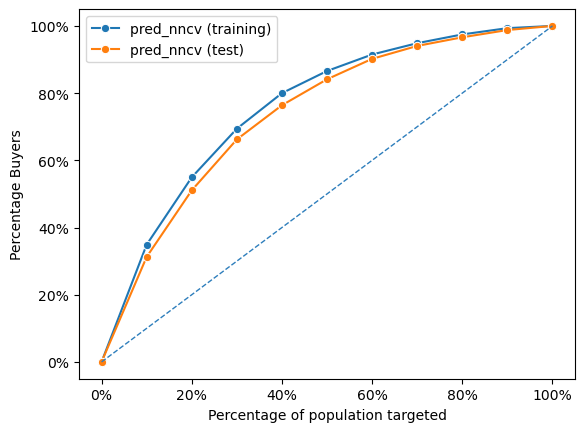

In [72]:
dct = {
    "training": pred.query("rnd_30k == 1"),
    "test": pred.query("rnd_30k == 0"),
}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_nncv", qnt=10)

The AUC for `pred_logit_ad` is 0.703 in the test sample and is 0.778 for `pred_nn_cv` in the test sample.

- Calculate the profit improvement of using the neural network "ad" model and the logistic regression "ad" model to target the best 30,000 customers out of the 120,000K customers that are not in group 2.

In [73]:
result = (
    pred.query("rnd_30k == 0")
    .sort_values("pred_nncv", ascending=False)
    .iloc[:30000]
    .converted_yes.agg(customers="count", converted="sum", conv_rate="mean")
)

In [74]:
conv_rate_ad_scoring_nn_model = result["conv_rate"]
result

customers    30000.000000
converted     9293.000000
conv_rate        0.309767
Name: converted_yes, dtype: float64

In [75]:
profit_ad_scoring_nn_model = result["converted"] * 14.99 - result["customers"] * 1.5
format(profit_ad_scoring_nn_model, ",.2f")

'94,302.07'

In [76]:
pred["pred_all"] = 1
profit_ad_scoring_nn_model = rsm.evalbin(
    pred.query("rnd_30k == 0").sort_values("pred_nncv", ascending=False).iloc[:30000],
    "converted",
    "yes",
    "pred_all",
    cost=1.5,
    margin=14.99,
).loc[0, "profit"]
format(profit_ad_scoring_nn_model, ",.2f")

'94,302.07'

In [77]:
rsm.md(
    f"""
Using the Neural Network model increases conversion rates from {100 * conv_rate_ad_scoring_ad_model:.2f}% to
{100 * conv_rate_ad_scoring_nn_model:.2f}%. The benefit of the ad campaign, if the NN model
is used to select customers, is {profit_ad_scoring_nn_model:,.0f} -
{profit_ad_scoring_ad_model:,.0f} = {profit_ad_scoring_nn_model - profit_ad_scoring_ad_model:,.0f}.
"""
)


Using the Neural Network model increases conversion rates from 27.39% to
30.98%. The benefit of the ad campaign, if the NN model
is used to select customers, is 94,302 -
78,173 = 16,129.


- Train a random forest on the sample of customers who were exposed to the ad campaign.

In [78]:
rfc = rsm.model.rforest(
    data={"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
    n_estimators=500,
    max_features=int(len(evar) ** 0.5),
    random_state=1234,
)
rfc.summary()


Random Forest
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 25)
Nr. of observations  : 30,000
max_features         : 4 (4)
n_estimators         : 500
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.776

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_no  AcquiredSpaceship_y

Random Forest with cross validation and grid search

In [79]:
param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(1, 10),
}
scoring = {"AUC": "roc_auc"}

In [80]:
if os.path.exists("cv-objects/rfc-cross-validation-object.pkl"):
    rfc_cvs = rsm.load_state("cv-objects/rfc-cross-validation-object.pkl")["rfc_cvs"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    rfc_cvs = GridSearchCV(
        rfc.fitted, param_grid, scoring=scoring, cv=stratified_k_fold, n_jobs=4, refit=list(scoring.keys())[0], verbose=5,
    ).fit(rfc.data_onehot, rfc.data.converted)
    # saving the cv object for RanfomForest for later use
    rsm.save_state({"rfc_cvs": rfc_cvs}, "cv-objects/rfc-cross-validation-object.pkl")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [81]:
rfc_cvs.best_params_

{'max_features': 4, 'n_estimators': 500}

In [82]:
rfc_cvs.best_score_

0.7769501116154698

In [83]:
pd.DataFrame(rfc_cvs.cv_results_).sort_values("rank_test_AUC").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
19,8.219811,0.039161,0.336906,0.002491,4,500,"{'max_features': 4, 'n_estimators': 500}",0.774106,0.785711,0.773298,0.761332,0.790304,0.776950,0.010202,1
18,6.545841,0.028675,0.269259,0.001027,4,400,"{'max_features': 4, 'n_estimators': 400}",0.773337,0.785115,0.774259,0.761662,0.789140,0.776703,0.009685,2
29,10.654226,0.058360,0.322064,0.001800,6,500,"{'max_features': 6, 'n_estimators': 500}",0.775640,0.786222,0.771342,0.762048,0.786750,0.776400,0.009335,3
17,4.918910,0.021930,0.201854,0.001137,4,300,"{'max_features': 4, 'n_estimators': 300}",0.773007,0.783932,0.773173,0.761123,0.789202,0.776088,0.009751,4
24,9.444766,0.062942,0.327618,0.002366,5,500,"{'max_features': 5, 'n_estimators': 500}",0.773821,0.784042,0.772412,0.763302,0.786670,0.776050,0.008454,5
22,5.644639,0.032932,0.196249,0.001879,5,300,"{'max_features': 5, 'n_estimators': 300}",0.774815,0.784690,0.772569,0.762875,0.784703,0.775930,0.008206,6
23,7.508083,0.035368,0.260619,0.001937,5,400,"{'max_features': 5, 'n_estimators': 400}",0.774590,0.784495,0.771863,0.762540,0.786141,0.775926,0.008663,7
28,8.474345,0.041172,0.257408,0.002764,6,400,"{'max_features': 6, 'n_estimators': 400}",0.775657,0.785302,0.771439,0.760607,0.786178,0.775837,0.009464,8
34,11.839001,0.093636,0.312588,0.003256,7,500,"{'max_features': 7, 'n_estimators': 500}",0.773466,0.784192,0.772061,0.761722,0.787282,0.775745,0.009164,9
14,7.004309,0.054849,0.355038,0.002841,3,500,"{'max_features': 3, 'n_estimators': 500}",0.772885,0.783090,0.771113,0.760263,0.790328,0.775536,0.010351,10


In [84]:
evar

['GameLevel',
 'NumGameDays',
 'NumGameDays4Plus',
 'NumInGameMessagesSent',
 'NumSpaceHeroBadges',
 'NumFriendRequestIgnored',
 'NumFriends',
 'AcquiredSpaceship',
 'AcquiredIonWeapon',
 'TimesLostSpaceship',
 'TimesKilled',
 'TimesCaptain',
 'TimesNavigator',
 'PurchasedCoinPackSmall',
 'PurchasedCoinPackLarge',
 'NumAdsClicked',
 'DaysUser',
 'UserConsole',
 'UserHasOldOS']

In [85]:
rfc_cv = rsm.model.rforest(
    data={"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1]},
    rvar="converted",
    lev="yes",
    evar=evar,
    random_state=1234,
    **rfc_cvs.best_params_
)
rfc_cv.summary()

Random Forest
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 25)
Nr. of observations  : 30,000
max_features         : 4 (4)
n_estimators         : 500
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.776

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_no  AcquiredSpaceship_y

In [86]:
pred.loc[pred.rnd_30k == 1, "pred_rfcv_oob"] = rfc_cv.predict()["prediction"]

In [87]:
pred.loc[pred.rnd_30k == 0, "pred_rfcv_oob"] = rfc_cv.predict(cg_ad_treatment[cg_ad_treatment.rnd_30k == 0])["prediction"]

In [88]:
pred["pred_rfcv"] = rfc_cv.predict(cg_ad_treatment)["prediction"]

In [89]:
pred

,rnd_30k,converted_yes,converted,pred_nn1,pred_nncv,pred_logit_ad,pred_all,pred_rfcv_oob,pred_rfcv
109438,0,0,no,0.126276,0.019146,0.130246,1,0.002000,0.002
49977,1,0,no,0.046237,0.018329,0.041218,1,0.074627,0.030
99506,0,0,no,0.055321,0.024380,0.052002,1,0.034000,0.034
411831,0,1,yes,0.340940,0.396509,0.329918,1,0.344000,0.344
82610,0,0,no,0.075883,0.093563,0.074874,1,0.054000,0.054
...,...,...,...,...,...,...,...,...,...
172637,1,0,no,0.103914,0.009828,0.107154,1,0.005525,0.002
87840,0,0,no,0.059992,0.042688,0.057251,1,0.048000,0.048
143309,0,0,no,0.059547,0.090548,0.056848,1,0.090000,0.090
159361,0,0,no,0.107279,0.013659,0.110083,1,0.086000,0.086


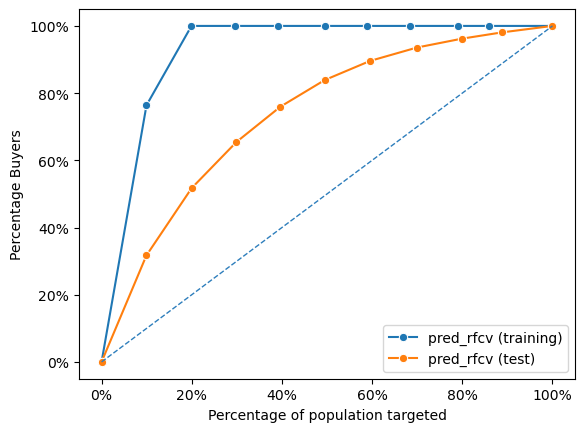

In [90]:
dct = {
    "training": pred.query("rnd_30k == 1"),
    "test": pred.query("rnd_30k == 0"),
}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_rfcv", qnt=10)

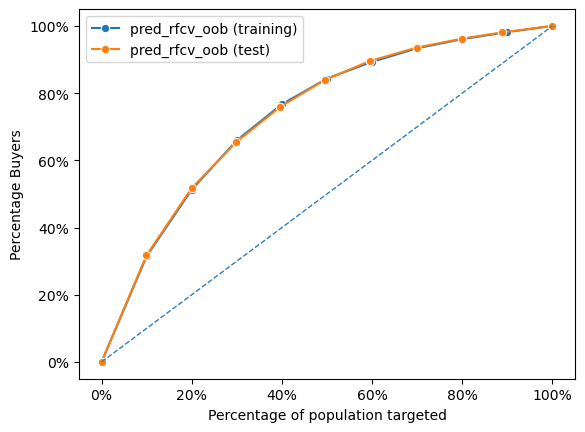

In [91]:
fig = rsm.gains_plot(dct, "converted", "yes", "pred_rfcv_oob", qnt=10)

In [92]:
pred

,rnd_30k,converted_yes,converted,pred_nn1,pred_nncv,pred_logit_ad,pred_all,pred_rfcv_oob,pred_rfcv
109438,0,0,no,0.126276,0.019146,0.130246,1,0.002000,0.002
49977,1,0,no,0.046237,0.018329,0.041218,1,0.074627,0.030
99506,0,0,no,0.055321,0.024380,0.052002,1,0.034000,0.034
411831,0,1,yes,0.340940,0.396509,0.329918,1,0.344000,0.344
82610,0,0,no,0.075883,0.093563,0.074874,1,0.054000,0.054
...,...,...,...,...,...,...,...,...,...
172637,1,0,no,0.103914,0.009828,0.107154,1,0.005525,0.002
87840,0,0,no,0.059992,0.042688,0.057251,1,0.048000,0.048
143309,0,0,no,0.059547,0.090548,0.056848,1,0.090000,0.090
159361,0,0,no,0.107279,0.013659,0.110083,1,0.086000,0.086


- Compare the performance of the random forest "ad" model and the logistic regression "ad" model from Part IV using data from the 120,000K customers that are not in group 2. Use gains curves and AUC for the comparison. What did we find?

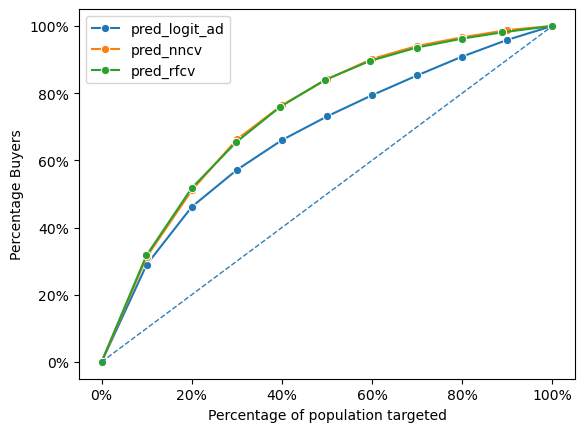

In [93]:
fig = rsm.gains_plot(
    pred[pred.rnd_30k == 0], "converted", "yes", ["pred_logit_ad", "pred_nncv", "pred_rfcv"], qnt=10
)

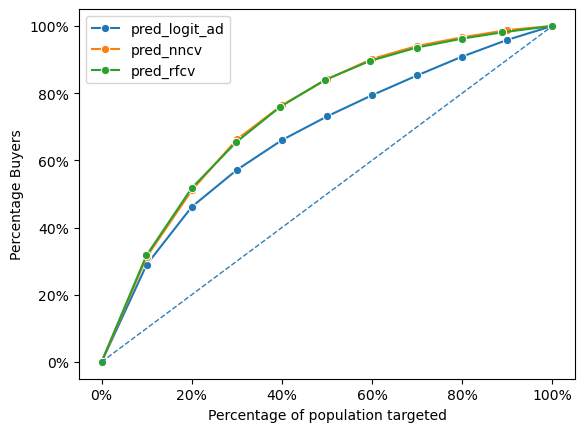

In [94]:
fig = rsm.gains_plot(
    pred[pred.rnd_30k == 0], "converted", "yes", ["pred_logit_ad", "pred_nncv", "pred_rfcv"], qnt=10
)

In [95]:
cg_ad_treatment["pred_all"] = 1
# profit note useful here because contact is much < 1
rsm.evalbin(
    pred.query("rnd_30k == 0"),
    "converted",
    "yes",
    ["pred_logit_ad", "pred_nncv", "pred_rfcv"],
    cost=1.5,
    margin=14.99,
)[["predictor", "AUC"]]

,predictor,AUC
0,pred_logit_ad,0.703
1,pred_nncv,0.779
2,pred_rfcv,0.778


- Calculate the profit improvement of using the random forest "ad" model and the logistic regression “ad” model to target the best 30,000 customers out of the 120,000K customers that are not in group 2.

In [96]:
result = (
    pred.query("rnd_30k == 0")
    .sort_values("pred_rfcv", ascending=False)
    .iloc[:30000]
    .converted_yes.agg(customers="count", converted="sum", conv_rate="mean")
)

conv_rate_ad_scoring_rf_model = result["conv_rate"]
result

customers    30000.0000
converted     9318.0000
conv_rate        0.3106
Name: converted_yes, dtype: float64

In [97]:
profit_ad_scoring_rf_model = result["converted"] * 14.99 - result["customers"] * 1.5
format(profit_ad_scoring_rf_model, ",.2f")

'94,676.82'

In [98]:
pred["pred_all"] = 1
profit_ad_scoring_rf_model = rsm.evalbin(
    pred.query("rnd_30k == 0").sort_values("pred_rfcv", ascending=False).iloc[:30000],
    "converted",
    "yes",
    "pred_all",
    cost=1.5,
    margin=14.99,
).loc[0, "profit"]
format(profit_ad_scoring_rf_model, ",.2f")

'94,676.82'

In [99]:
rsm.md(
    f"""
Using the Random Forest model increases conversion rates from {100 * conv_rate_ad_scoring_ad_model:.2f}% to
{100 * conv_rate_ad_scoring_rf_model:.2f}%. The benefit of the ad campaign, if the Random Forest model
is used to select customers, is {profit_ad_scoring_rf_model:,.0f} -
{profit_ad_scoring_ad_model:,.0f} = {profit_ad_scoring_rf_model - profit_ad_scoring_ad_model:,.0f}.
"""
)


Using the Random Forest model increases conversion rates from 27.39% to
31.06%. The benefit of the ad campaign, if the Random Forest model
is used to select customers, is 94,677 -
78,173 = 16,504.


In [100]:
rsm.md(
    f"""
Using the Random Forest model instead of the Neural Network model changes conversion rates from {100 * conv_rate_ad_scoring_nn_model:.6f}% to
{100 * conv_rate_ad_scoring_rf_model:.6f}%. The impact of the ad campaign, if the Random Forest model
rather than the Neural Network is used to select customers, is {profit_ad_scoring_rf_model:,.0f} -
{profit_ad_scoring_nn_model:,.0f} = {profit_ad_scoring_rf_model - profit_ad_scoring_nn_model:,.0f}.
"""
)


Using the Random Forest model instead of the Neural Network model changes conversion rates from 30.976667% to
31.060000%. The impact of the ad campaign, if the Random Forest model
rather than the Neural Network is used to select customers, is 94,677 -
94,302 = 375.
